In [1]:
# !pip install craft-text-detector opencv-python matplotlib shapely

import os
import cv2
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon as ShapelyPoly

import torchvision.models.vgg as vgg_module
if not hasattr(vgg_module, 'model_urls'):
    vgg_module.model_urls = {
        'vgg16_bn': 'https://download.pytorch.org/models/vgg16_bn-6c64b313.pth'
    }
print("✅ Torchvision compatibility patch applied")

from craft_text_detector import Craft
from craft_text_detector import craft_utils

# Enable CUDA if available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if DEVICE.type == "cuda":
    print(f"✅ Running on GPU: {torch.cuda.get_device_name(0)}")
else:
    torch.set_num_threads(os.cpu_count())
    print(f"✅ Running on CPU with {torch.get_num_threads()} threads")

# ===== NUMPY COMPATIBILITY PATCH =====
def patched_adjustResultCoordinates(polys, ratio_w, ratio_h, ratio_net=2):
    """Patched version that handles numpy array creation properly"""
    if len(polys) > 0:
        for k in range(len(polys)):
            if polys[k] is not None:
                polys[k] *= (ratio_w * ratio_net, ratio_h * ratio_net)
    return polys

craft_utils.adjustResultCoordinates = patched_adjustResultCoordinates

_original_np_array = np.array

def _patched_np_array(arr_input, dtype=None, **kwargs):
    """Patched numpy array that uses object dtype for heterogeneous sequences"""
    try:
        return _original_np_array(arr_input, dtype=dtype, **kwargs)
    except ValueError as e:
        error_msg = str(e)
        if "inhomogeneous shape" in error_msg or "setting an array element with a sequence" in error_msg:
            return _original_np_array(arr_input, dtype=object)
        raise

np.array = _patched_np_array
print("✅ Comprehensive CRAFT numpy compatibility patches applied")


✅ Torchvision compatibility patch applied
✅ Running on GPU: NVIDIA GeForce RTX 2060
✅ Comprehensive CRAFT numpy compatibility patches applied
✅ Running on GPU: NVIDIA GeForce RTX 2060
✅ Comprehensive CRAFT numpy compatibility patches applied


In [2]:
BASE_DIR = os.path.dirname(os.getcwd())  # Go up one level from CRAFT folder

IMG_DIR = os.path.join(BASE_DIR, "test-images", "ch4_test_images")
GT_DIR = os.path.join(BASE_DIR, "test-images", "Challenge4_Test_Task1_GT")
OUTPUT_DIR = os.path.join(BASE_DIR, "outputs")

os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"📂 Images: {IMG_DIR}")
print(f"📂 Ground Truth: {GT_DIR}")
print(f"📂 Output: {OUTPUT_DIR}")

📂 Images: x:\Project I 7th sem\test-images\ch4_test_images
📂 Ground Truth: x:\Project I 7th sem\test-images\Challenge4_Test_Task1_GT
📂 Output: x:\Project I 7th sem\outputs


In [3]:
tools = Craft(    
    crop_type="poly",
    text_threshold = 0.52,
    link_threshold = 0.40,
    low_text = 0.30,
    long_size = 2240,
    cuda = True            # Resolution for inference
)

print("✅ CRAFT model loaded)")


c:\ProgramData\anaconda3\envs\py38\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\ProgramData\anaconda3\envs\py38\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


✅ CRAFT model loaded)


In [4]:
def load_gt(gt_path):
    boxes, ignores = [], []
    if not os.path.exists(gt_path):
        return boxes, ignores

    with open(gt_path, "r", encoding="utf-8-sig") as f:
        for line in f:
            parts = line.strip().split(",")
            if len(parts) < 9:
                continue
            try:
                coords = np.array(parts[:8], dtype=np.float32).reshape(4, 2)
                text = parts[8]
                if text == "###":
                    ignores.append(coords)
                else:
                    boxes.append(coords)
            except:
                continue
    return boxes, ignores


def compute_iou(box_a, box_b):
    try:
        poly_a = ShapelyPoly(box_a)
        poly_b = ShapelyPoly(box_b)
        if not poly_a.is_valid or not poly_b.is_valid:
            return 0.0
        inter = poly_a.intersection(poly_b).area
        union = poly_a.area + poly_b.area - inter
        return inter / union if union > 0 else 0.0
    except:
        return 0.0


In [5]:
gt_cache = {}

for gt_file in os.listdir(GT_DIR):
    if gt_file.endswith(".txt"):
        gt_path = os.path.join(GT_DIR, gt_file)
        gt_cache[gt_file] = load_gt(gt_path)

print(f"✅ Cached {len(gt_cache)} GT files")


✅ Cached 500 GT files


Found 500 images


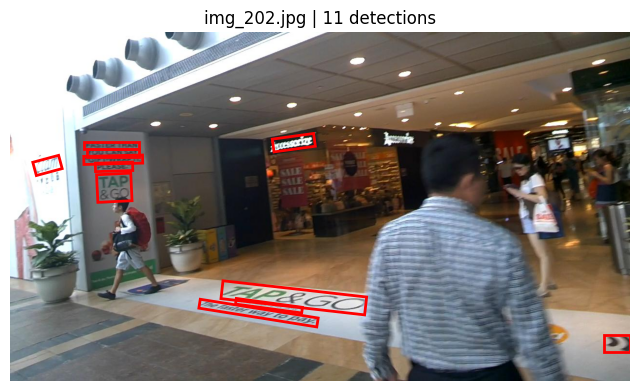

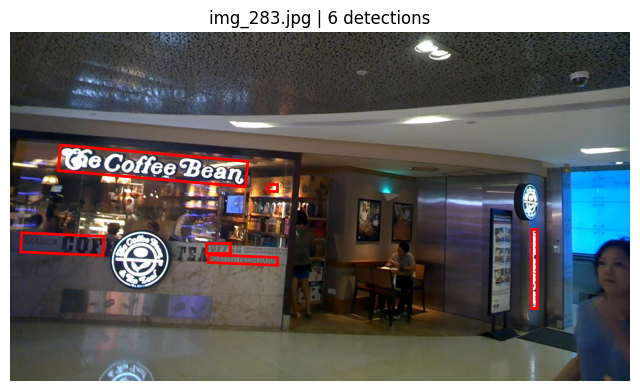

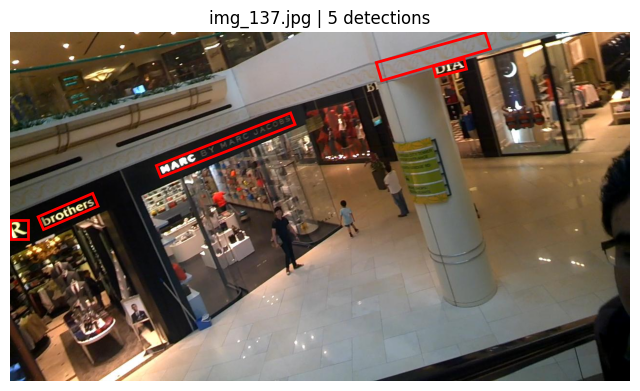

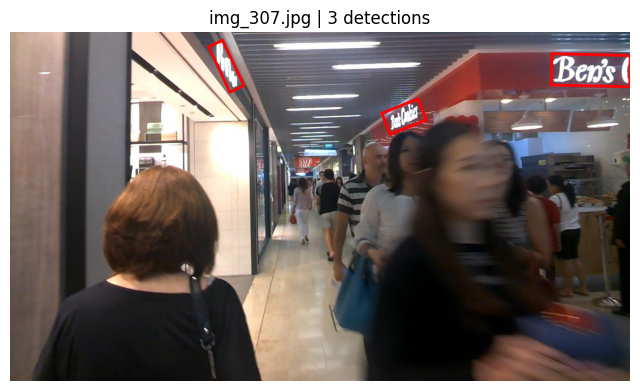

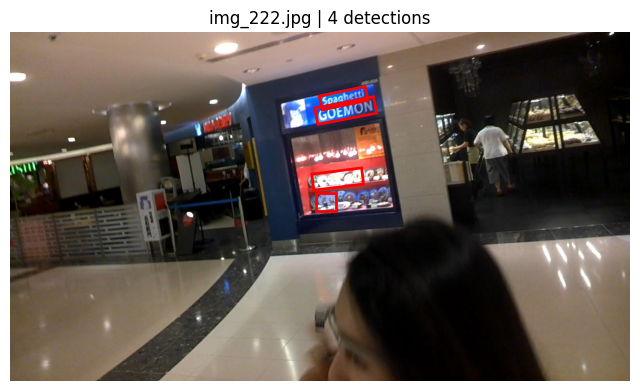

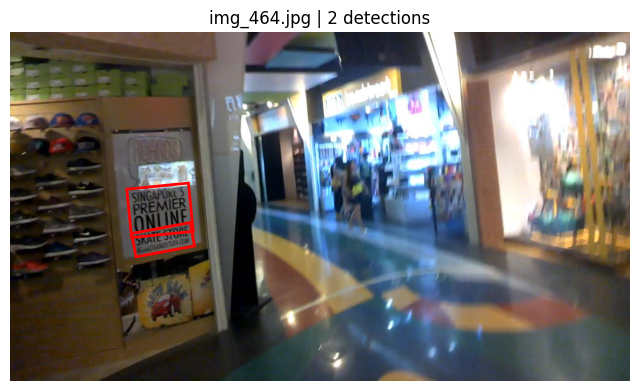

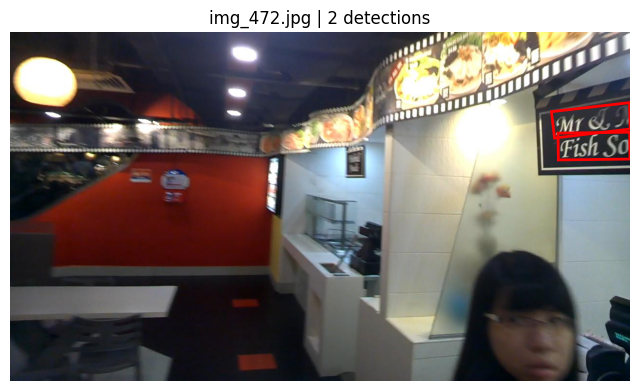

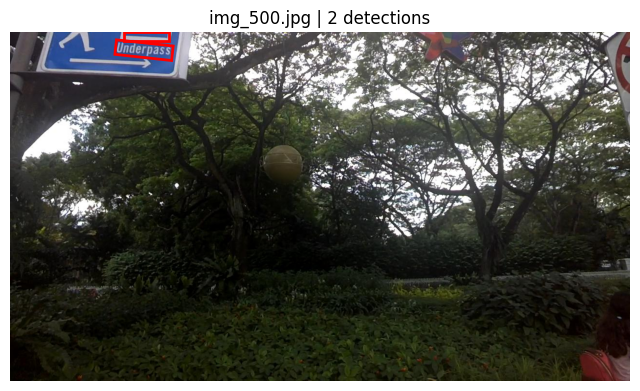

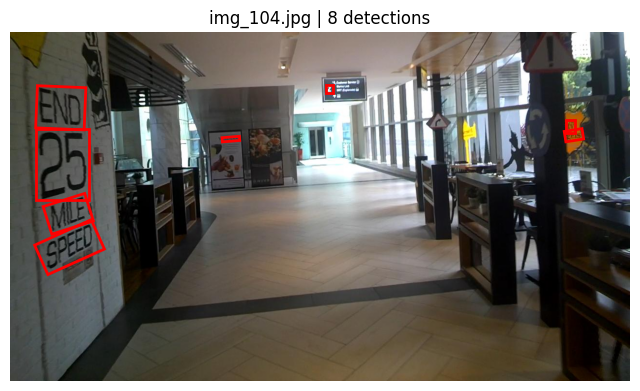

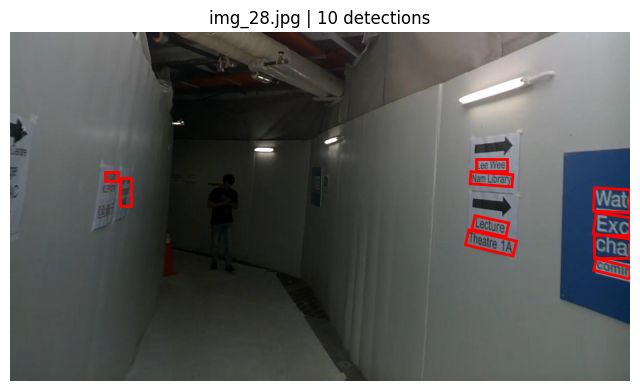

In [6]:
image_files = sorted([
    f for f in os.listdir(IMG_DIR)
    if f.lower().endswith((".jpg", ".png"))
])

print(f"Found {len(image_files)} images")

def visualize_batch(files, model, num_images=10):
    samples = random.sample(files, min(num_images, len(files)))

    for name in samples:
        path = os.path.join(IMG_DIR, name)
        pred = model.detect_text(path)
        boxes = pred["boxes"]

        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(8, 8))
        plt.imshow(img)
        ax = plt.gca()

        for box in boxes:
            ax.add_patch(plt.Polygon(box, fill=False, edgecolor="red", linewidth=2))

        plt.title(f"{name} | {len(boxes)} detections")
        plt.axis("off")
        plt.show()


visualize_batch(image_files, tools, num_images=10)

In [7]:
from tqdm import tqdm
import cv2
import numpy as np
from craft_text_detector.predict import get_prediction

# --- Create output directory for CRAFT predictions ---
CRAFT_OUTPUT_DIR = r"X:\Project I 7th sem\outputs\craft"
os.makedirs(CRAFT_OUTPUT_DIR, exist_ok=True)
print(f"📂 CRAFT predictions will be saved to: {CRAFT_OUTPUT_DIR}")

# --- Accumulators ---
all_box_scores = []
tp_scores = []
fp_scores = []

total_tp, total_fp, total_fn = 0, 0, 0

print(f"🚀 Processing {len(image_files)} images...")

for idx, filename in enumerate(tqdm(image_files, desc="Evaluating", unit="image")):
    img_path = os.path.join(IMG_DIR, filename)

    # --- Load image ---
    img = cv2.imread(img_path)
    if img is None:
        continue

    # --- Inference (RAW prediction with score maps) ---
    prediction = get_prediction(
        image=img,
        craft_net=tools.craft_net,
        refine_net=None,                # keep OFF for now
        text_threshold=tools.text_threshold,
        link_threshold=tools.link_threshold,
        low_text=tools.low_text,
        cuda=tools.cuda,
        long_size=tools.long_size,
        poly=True
    )

    pred_boxes = prediction["boxes"]
    text_map = prediction["heatmaps"]["text_score_heatmap"]   # Correct key path

    # --- Save predictions to txt file ---
    base_name = os.path.splitext(filename)[0]
    pred_txt_path = os.path.join(CRAFT_OUTPUT_DIR, f"{base_name}.txt")
    with open(pred_txt_path, 'w', encoding='utf-8') as f:
        for pred in pred_boxes:
            # Convert polygon to integers and format as x1,y1,x2,y2,x3,y3,x4,y4
            pts = pred.astype(np.int32)
            coords = [str(int(coord)) for pt in pts for coord in pt]
            line = ','.join(coords) + '\n'
            f.write(line)

    # --- Load GT ---
    gt_name = "gt_" + base_name + ".txt"
    gt_boxes, ignore_boxes = gt_cache.get(gt_name, ([], []))

    if idx == 0:
        print(f"[DEBUG] Available keys: {prediction.keys()}")
        print(f"[DEBUG] GT boxes: {len(gt_boxes)}, Ignore boxes: {len(ignore_boxes)}")

    matched_gt = [False] * len(gt_boxes)

    for pred in pred_boxes:
        pred = pred.astype(np.int32)

        # --- Compute mean text score ---
        h, w = text_map.shape[:2]
        mask = np.zeros((h, w), dtype=np.uint8)
        cv2.fillPoly(mask, [pred], 1)

        if mask.sum() == 0:
            continue

        score = float(text_map[mask == 1].mean())
        all_box_scores.append(score)

        # --- Ignore regions ---
        ignored = False
        for ig in ignore_boxes:
            if compute_iou(pred, ig) > 0.5:
                ignored = True
                break
        if ignored:
            continue

        # --- Match GT ---
        hit = False
        for i, gt in enumerate(gt_boxes):
            if not matched_gt[i] and compute_iou(pred, gt) > 0.5:
                matched_gt[i] = True
                total_tp += 1
                tp_scores.append(score)
                hit = True
                break

        if not hit:
            total_fp += 1
            fp_scores.append(score)

    total_fn += matched_gt.count(False)

print("✅ Evaluation complete")
print(f"✅ All predictions saved to: {CRAFT_OUTPUT_DIR}")


📂 CRAFT predictions will be saved to: X:\Project I 7th sem\outputs\craft
🚀 Processing 500 images...


Evaluating:   0%|          | 1/500 [00:00<05:41,  1.46image/s]

[DEBUG] Available keys: dict_keys(['boxes', 'boxes_as_ratios', 'polys', 'polys_as_ratios', 'heatmaps', 'times'])
[DEBUG] GT boxes: 0, Ignore boxes: 8


Evaluating: 100%|██████████| 500/500 [06:28<00:00,  1.29image/s]

✅ Evaluation complete
✅ All predictions saved to: X:\Project I 7th sem\outputs\craft


In [8]:
precision = total_tp / (total_tp + total_fp + 1e-6)
recall = total_tp / (total_tp + total_fn + 1e-6)
f1 = 2 * precision * recall / (precision + recall + 1e-6)

print("\n" + "=" * 45)
print("📊 FINAL ICDAR EVALUATION")
print(f"TP: {total_tp}")
print(f"FP: {total_fp}")
print(f"FN: {total_fn}")
print("-" * 45)
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")
print("=" * 45)



📊 FINAL ICDAR EVALUATION
TP: 1576
FP: 748
FN: 501
---------------------------------------------
Precision: 0.6781
Recall:    0.7588
F1-score:  0.7162


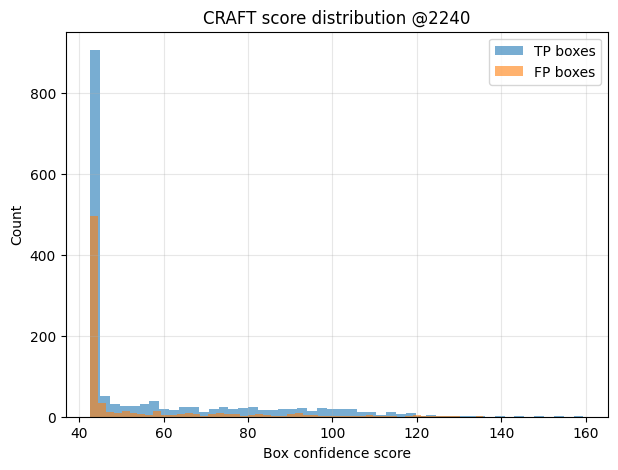

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))

plt.hist(tp_scores, bins=50, alpha=0.6, label="TP boxes")
plt.hist(fp_scores, bins=50, alpha=0.6, label="FP boxes")

plt.xlabel("Box confidence score")
plt.ylabel("Count")
plt.title("CRAFT score distribution @2240")
plt.legend()
plt.grid(alpha=0.3)

plt.show()
